Необходимо решить задачу классификации с использованием SVM и подобрать наилучшее ядро.

In [28]:
#импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time

from scipy.stats import kstest
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials


In [29]:
#загрузка датасета

df = pd.read_csv('data/winequality-red.csv', delimiter=';')

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Анализ данных

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [31]:
#оценка пропусков
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [32]:
import warnings
warnings.filterwarnings('ignore')

Text(0.5, 1.0, 'Features distributions')

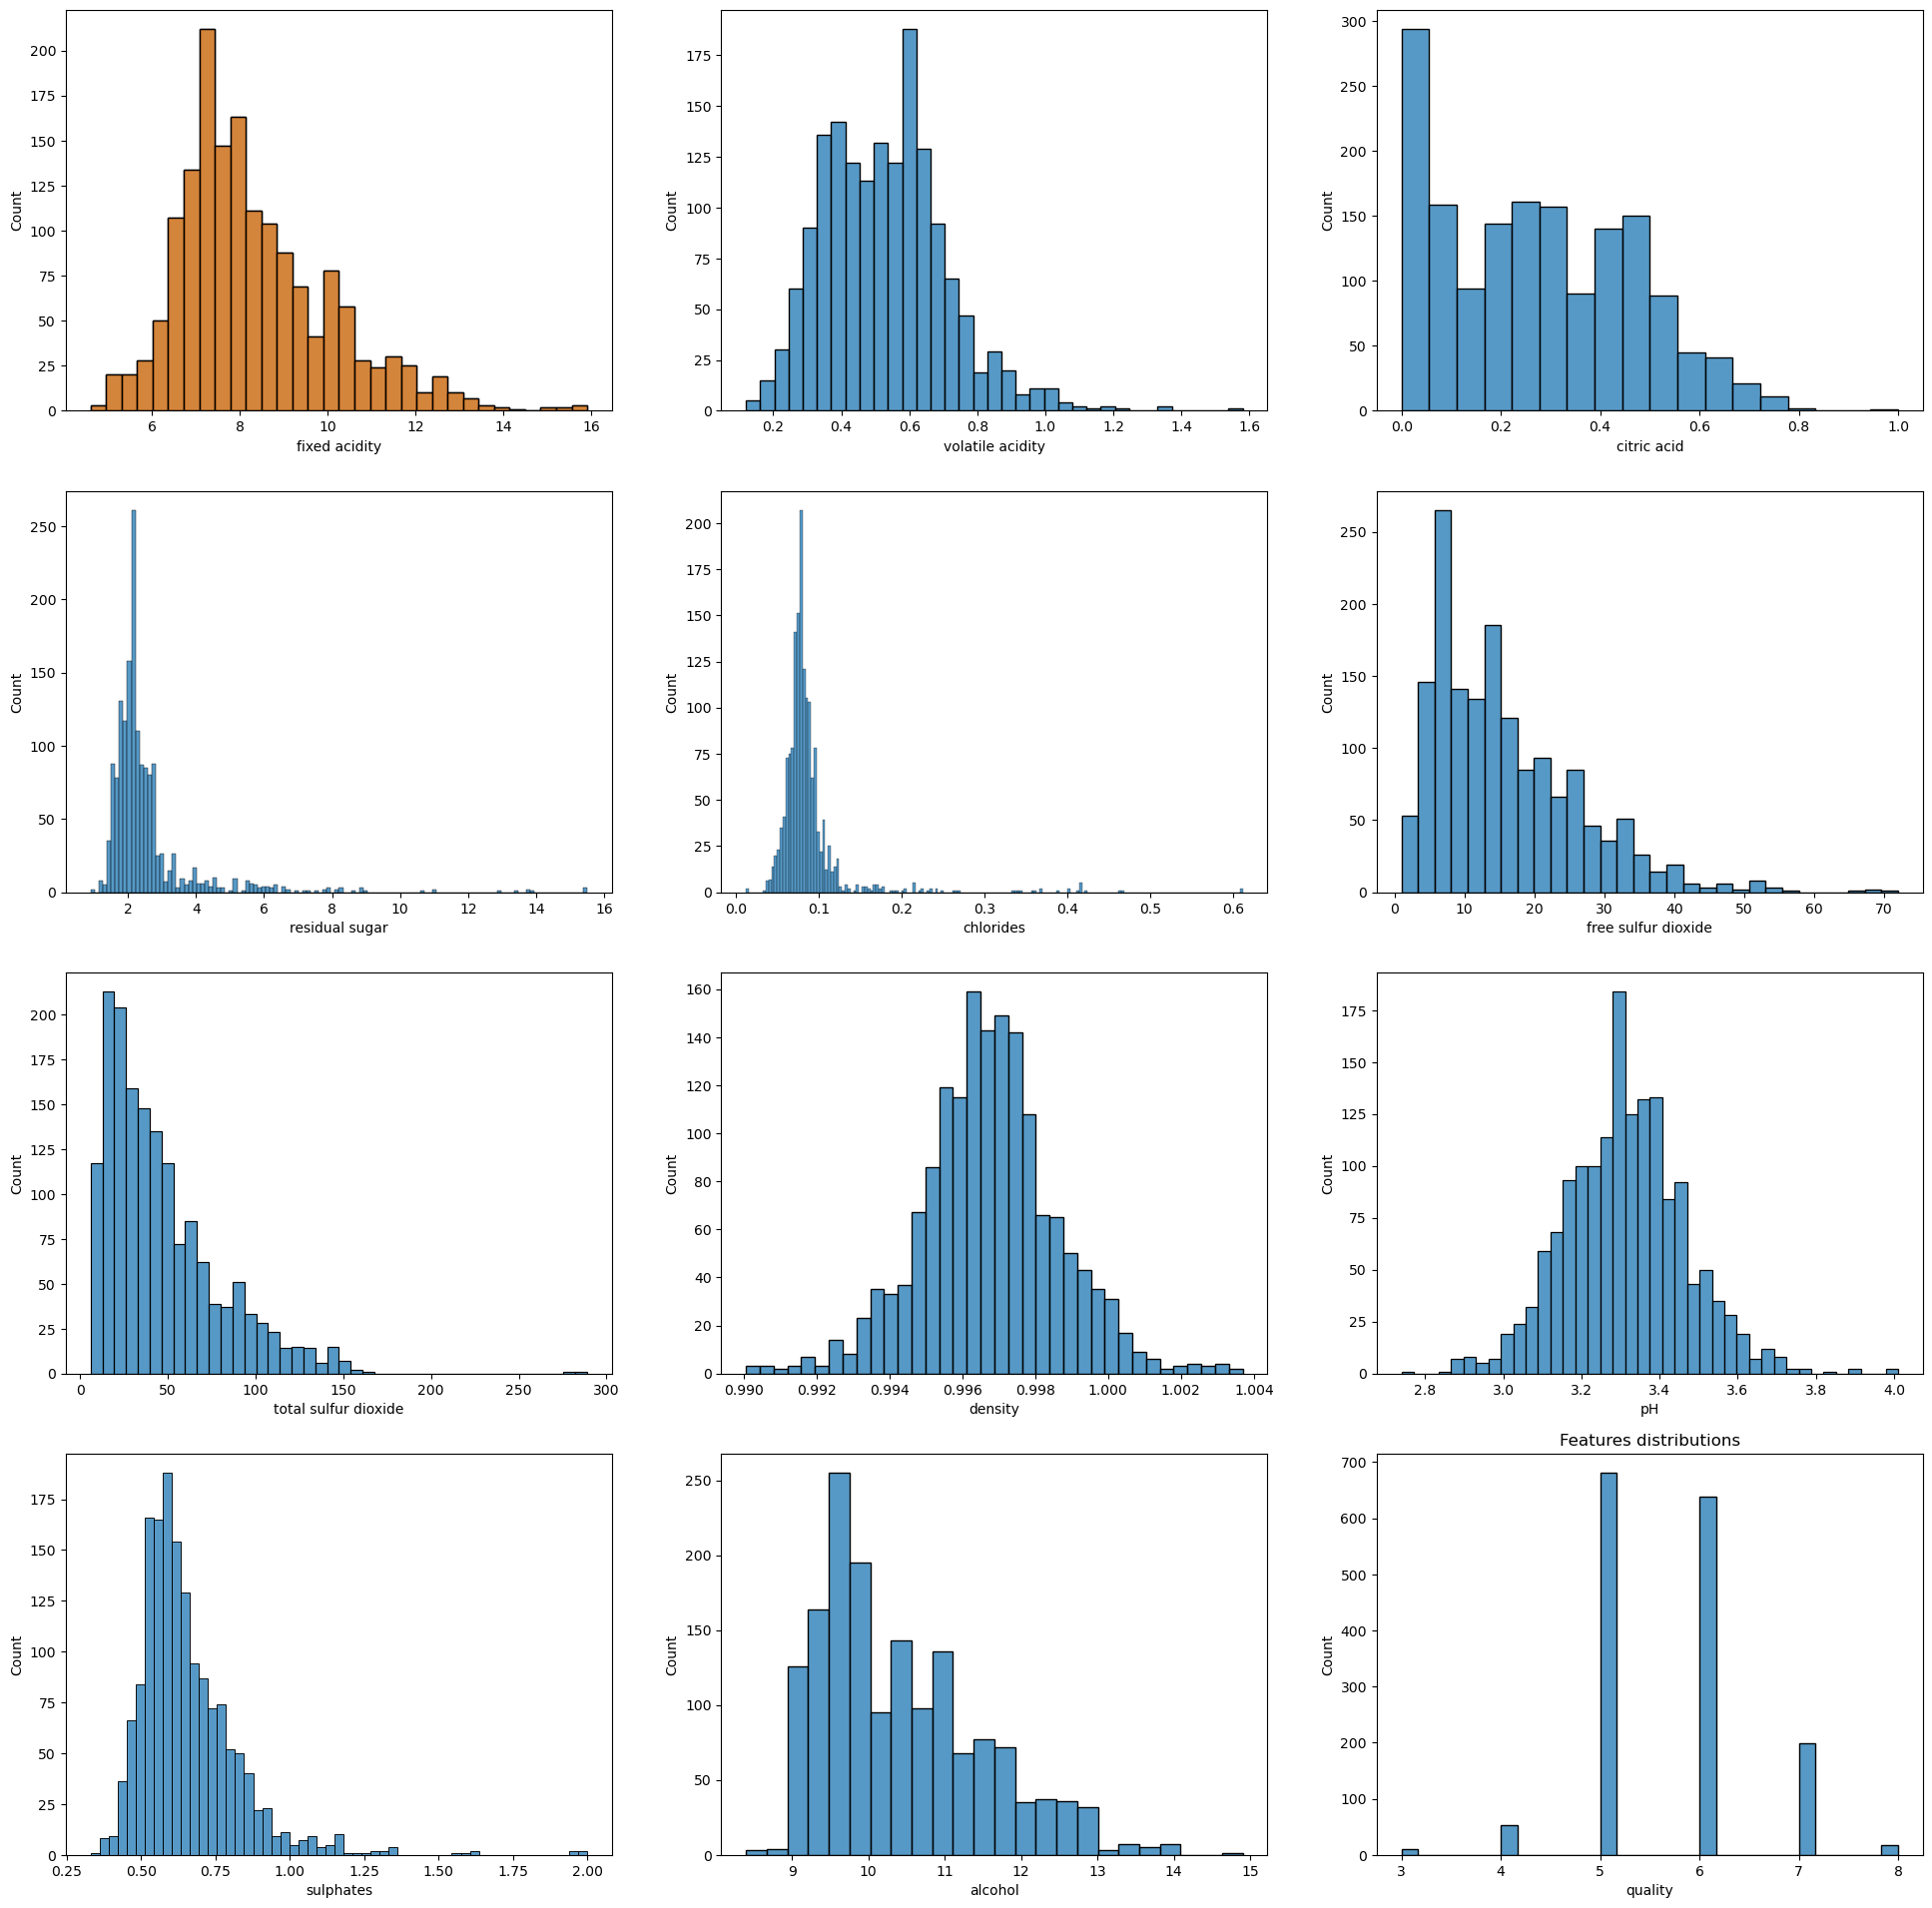

In [33]:
fig, axes = plt.subplots(4,3, figsize=(24,24))
sns.histplot(df['fixed acidity'], ax=axes[0,0])

i = 0
j = 0

for col in df.columns:

    if j>2:
        i+=1
        j=0
    sns.histplot(df[col], ax=axes[i,j]) 
    j+=1


plt.title('Features distributions')


In [34]:
# оценка нормальности распределения данных

def ks_test(data, alpha=0.05):
    
    stat, p = kstest(data, 'norm')
    
    if p>alpha:
        return 'Normal'
    else:
        return 'Abnormal'

print('Distributions')
for col in df.drop('quality', axis=1).columns:
    print(f'{col} - {ks_test(df[col])}')

Distributions
fixed acidity - Abnormal
volatile acidity - Abnormal
citric acid - Abnormal
residual sugar - Abnormal
chlorides - Abnormal
free sulfur dioxide - Abnormal
total sulfur dioxide - Abnormal
density - Abnormal
pH - Abnormal
sulphates - Abnormal
alcohol - Abnormal


Text(0.5, 1.0, 'Correlation heatmap')

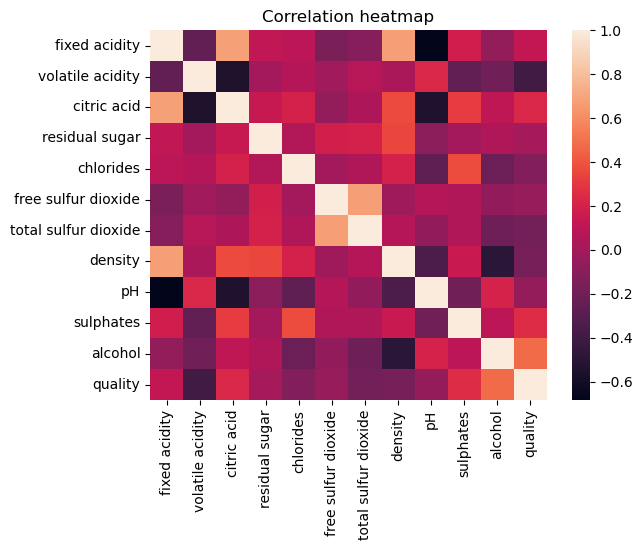

In [35]:
#оценка корреляции

plt.plot()
sns.heatmap(df.corr())
plt.title('Correlation heatmap')

Среди представленных данных нет, которые были бы распределены нормально.

### Преобразование целевой переменной в категориальный признак

In [36]:
# Encode quality-feture where 1 - is good wine, 0 - bad
df['quality'] = df['quality'].apply(lambda x: 1 if x>6.5 else 0)
df.quality.value_counts()

quality
0    1382
1     217
Name: count, dtype: int64

In [37]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


### Преобразование признаков с помощью StandardScaler()

In [38]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df.drop('quality', axis=1))
scaled = pd.DataFrame(data=scaled, columns=scaler.feature_names_in_)
scaled.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246


In [39]:
#присоедение преобразвоанных колонок с колонкой целевой переменной
df_sc = scaled.merge(df.quality, left_index=True, right_index=True)
df_sc.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,0
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,0
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,0
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,0
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,0


### Подготовка модели

In [40]:
X = df_sc.drop('quality', axis=1)
y = df_sc.quality

Подбор гиперпараметров

In [41]:
# Optuna

def objective(trial):
    
    C = trial.suggest_float('c', 0, 1)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])

    svc = SVC(C=C, gamma='scale', kernel=kernel)
    svc.fit(X, y)

    return svc.score(X, y)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-02-28 22:52:57,968] A new study created in memory with name: no-name-82961617-80d1-411a-92d4-29630cbf8941
[I 2024-02-28 22:52:57,994] Trial 0 finished with value: 0.8642901813633521 and parameters: {'c': 0.8113926302449871, 'kernel': 'linear'}. Best is trial 0 with value: 0.8642901813633521.
[I 2024-02-28 22:52:58,022] Trial 1 finished with value: 0.890556597873671 and parameters: {'c': 0.36059473734385217, 'kernel': 'poly'}. Best is trial 1 with value: 0.890556597873671.
[I 2024-02-28 22:52:58,063] Trial 2 finished with value: 0.8348968105065666 and parameters: {'c': 0.7133038456164769, 'kernel': 'sigmoid'}. Best is trial 1 with value: 0.890556597873671.
[I 2024-02-28 22:52:58,083] Trial 3 finished with value: 0.8642901813633521 and parameters: {'c': 0.23334806055287727, 'kernel': 'linear'}. Best is trial 1 with value: 0.890556597873671.
[I 2024-02-28 22:52:58,108] Trial 4 finished with value: 0.8805503439649781 and parameters: {'c': 0.13595843017183762, 'kernel': 'poly'}. Bes

In [42]:
study.best_params

{'c': 0.9952760885693973, 'kernel': 'poly'}

In [43]:
#Hyperopt

best_score=1.0

def objective(space):
    
    global best_score
    model = SVC(**space)   
    kfold = StratifiedKFold(n_splits=kFoldSplits, random_state=seed, shuffle=True)
    score = 1-cross_val_score(model, X, y, cv=kfold, scoring=metric, verbose=False).mean() 
    
    if (score < best_score):
        best_score=score
    
    return score 

In [44]:
space = {
      'C': hp.choice('C', np.arange(0.005,1.0,0.01)),
      'kernel': hp.choice('kernel',['linear', 'poly', 'rbf']),
      #'gamma':hp.choice('gamma', np.arange(100, df_sc.shape[0], 50))
}

In [45]:
n_iter_hopt = 100
seed = 42
metric = 'accuracy'
kFoldSplits = 5
trials = Trials() 

start = time.time()

best = fmin(objective, 
            space = space, 
            algo = tpe.suggest, 
            max_evals = n_iter_hopt,
            trials = trials,
            rstate = np.random.default_rng(seed))

elapsed_time_hopt = time.time() - start

100%|██████████| 100/100 [00:07<00:00, 12.85trial/s, best loss: 0.11194357366771168]


In [46]:
best

{'C': 95, 'kernel': 2}

### Обучение моделей на подобраных гиперпараметрах

In [62]:
clf_optuna = SVC(random_state=42, C=0.944, kernel='poly')

cross_val_score(clf_optuna, X, y, cv=5)

array([0.875     , 0.865625  , 0.86875   , 0.859375  , 0.85893417])

In [61]:
clf_hyperopt = SVC(random_state=42, C=0.95, kernel='poly')

cross_val_score(clf_hyperopt, X, y, cv=5)

array([0.878125  , 0.865625  , 0.86875   , 0.8625    , 0.85893417])

Выводы:
- Optuna и Hyperopt подобрали похожие гиперпараметры;
- При практически одинаковых гиперпараметрах моделей поличились практически одинаковые результаты.